# 第5章 （4）ランダムフォレスト

バギングは，決定木のように学習データに対してバイアスが小さく，バリアンスが大きな識別器に適した手法であるが，ブートストラップサンプリングによるため生成された決定木の間の相関が高くなる．

一般に，分散$\sigma^2$を持つ$M$個の独立な確率変数$X_i(i=1,\cdots,M)$の平均$\overline{X}=(1/M)\sum_{i=1}^{M}X_i$の分散は，${\rm Var}\{\overline{X}\}=\sigma^2/M$となるが，任意の2つの確率変数の間に正の相関$\rho$がある場合には，平均の分散は，
$$
{\rm Var}\{\overline{X}\}=\frac{1-\rho}{M}\sigma^2+\rho \sigma^2
$$
となる．

ブートストラップサンプル数の$M$を増やせば上の式の第１項は減少するが，第２項は減らない．ランダムフォレストは$\rho$を減らす仕組みを入れてバギングを強化した手法である．

<img src="work/4.png" width="600">

In [2]:
# 魚データ
# 特徴ベクトル：2次元（体長, 体重）
# ラベル数：2（サケ(A)とスズキ(B)）

# 確率密度関数で生成
# 分散共分散行列で楕円を指定
# ただし，データのオーバーラップを生じさせて，難しくする．
# トレーニングデータとテストデータを作成する．

import numpy as np
import pandas as pd

# 乱数の種を初期化
np.random.seed(0)

# データ数
numA = 200 # Aをサケ
numB = 200 # Bをスズキ
numAll = numA + numB

# 平均
muA = [-2,2]
muB = [2,-2]

# 共分散
cov = [[30,15],[15,30]]

# 入力信号を生成
xA, yA = np.random.multivariate_normal(muA, cov, numA).T
xB, yB = np.random.multivariate_normal(muB, cov, numB).T

# 教師信号を生成
clsA = [1 for i in range(numA)]
clsB = [0 for i in range(numB)]

# DataFrameに変換
dfA = pd.DataFrame(np.array([xA,yA,clsA]).T, columns=['cm','kg','cls'])
dfB = pd.DataFrame(np.array([xB,yB,clsB]).T, columns=['cm','kg','cls'])
dfAll = pd.concat([dfA,dfB],axis=0)
dfAll = dfAll.reset_index(drop=True)

import sklearn.preprocessing as skl
dfAll.cm = skl.scale(dfAll.cm) #正規化
dfAll.kg = skl.scale(dfAll.kg) #正規化

from sklearn.model_selection import train_test_split
X = dfAll[['cm','kg']].values
y = dfAll[['cls']].values
y = y.reshape(len(y),) # ベクトルにする
y = np.array(y, dtype=np.int64)


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'Tree': DecisionTreeClassifier(random_state=0),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(random_state=0), n_estimators=100, random_state=0),
    'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(random_state=0), n_estimators=100, random_state=0),
    'Forest': RandomForestClassifier(criterion='entropy',n_estimators=100)
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,0.69,1.0
Bagging,0.71,1.0
Forest,0.71,1.0
Tree,0.67,1.0


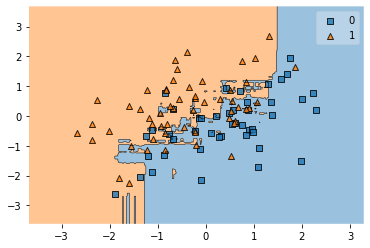

In [5]:
# 領域を表示
from mlxtend.plotting import plot_decision_regions
predicted = model.predict(X_test)
plot_decision_regions(X_test, y_test, model)

決定木，バギング，アダブースト，ランダムフォレストを比較した．結果的には，ランダムフォレストとバギングが性能が高く，また，ランダムフォレストは木の数を増やしても過学習することがなく，またパラメータ設定が簡単なため，一番オススメである．